In [1]:
import scipy.signal as sp
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import math
from matplotlib.widgets import Slider, Button
from scipy.interpolate import interp2d
import cv2

In [2]:
def generate_stimuli(pos = [0, 0], size=20):
    if type(pos) == list:
        pos = np.asarray(pos).reshape(1, len(pos))
        
    stims = np.zeros([size, size, pos.shape[0]])
    
    for i in range(pos.shape[0]):
        center = pos[i]
        x = round(pos[i, 0]) + int(size/2)
        y = round(pos[i, 1]) + int(size/2)
        
        stims[y, x, i] = 1
    
    return np.squeeze(stims), pos


def generate_prf(center = [0, 0], size=20, sd=10):
    x = np.arange(-int(size/2), int(size/2), 1, float)
    y = x[:,np.newaxis]
    
    prf =  np.exp(- ((x-center[0])**2 + (y-center[1])**2) / (2*sd**2))
    
    return prf


def generate_prf_warp(center = [0, 0], size=20, sd=10, y_warp = 1, x_warp = 1):
    x = np.arange(-int(size/2), int(size/2), 1, float)
    y = x[:,np.newaxis] * y_warp
    x = x * x_warp
    
    prf =  np.exp(- ((x-center[0])**2 + (y-center[1])**2) / (2*sd**2))
    
    prf /= prf.sum()
    
    return prf


def generate_voxels(deg_radius=20, n_eccentricities=10, prf_slope=0.2, prf_intercept = 0.6):
    # v1, v2 slope = 0.2
    # v3 = 0.25
    # hV4 = 0.5
    pos = np.linspace(0, deg_radius, n_eccentricities)
    xs = np.concatenate([-pos[:0:-1], pos])
    ys = xs[:, np.newaxis][::-1]

    voxels = []

    for x in xs.flatten():
        for y in ys.flatten():
            ecc = np.linalg.norm(np.array([x, y]))
            prf_size = ecc * prf_slope + prf_intercept

            voxels.append([x, y, ecc, prf_size])

    voxels = np.asarray(voxels)
    
    return voxels


def generate_isostim(eccentricity, n_pos, size):
    xstart = np.arange(0, 2*np.pi, 2*np.pi / n_pos)
    xstop = xstart + 2*np.pi / n_pos
    x = np.random.uniform(xstart, xstop)
    
    positions = eccentricity * np.array([np.sin(x), np.cos(x)]).T 
    
    stims, pos = generate_stimuli(positions, size = size)
    
    return stims, positions, x


def gen_pRFresponses(near_ecc, target_ecc, stims, prf_maps, voxels, positions):
    # near_ecc = 2
    # stim = stims[:, :, slice]
    # angle_s = angles[slice]
    # pos = positions[slice]
    # angle = np.arctan2(pos[1], pos[0])
    # coords = np.where(stim == 1)
    # threshold = 0.01
    target_idxs = np.where((voxels[:, 2] <= target_ecc + near_ecc) & (voxels[:, 2] >= target_ecc - near_ecc))
    target_voxels = voxels[target_idxs]
    target_prf_maps = prf_maps[:, :, target_idxs].squeeze()
    prf_responses = np.zeros([len(target_voxels), 6, stims.shape[-1]])     
    
    for s in range(stims.shape[-1]):
        stim = stims[:, :, s]
        prf_resps = []
        pos = positions[s]
        angle = np.arctan2(pos[1], pos[0])
        
        for i, v in enumerate(target_voxels):
            x, y, ecc, prf_size = v
            prf = target_prf_maps[:, :, i]
            prf_resp = stim.flatten() @ prf.flatten()
            vox_deg_in_rads = np.arctan2(y, x)

            vox_diff = angle - vox_deg_in_rads
            if vox_diff >= np.pi:
                vox_diff -= 2*np.pi
            elif vox_diff <= -np.pi:
                vox_diff += 2*np.pi
            
            prf_resps.append([x, y, ecc, vox_deg_in_rads, vox_diff, prf_resp])

        prf_responses[:, :, s] = np.asarray(prf_resps)
    
    return prf_responses


def gen_LTMstims(stims, size, filt_size = 20, sd = 4.5):
    filt = generate_prf(size = filt_size, sd = sd)
    ltm_stims = np.zeros([size, size, stims.shape[-1]])
    
    for s in range(stims.shape[-1]):
        stim = stims[:, :, s]
        stim_conv = sp.convolve2d(stim, filt, mode = 'same')
        #edge = int(stim_conv.shape[0]/2 - stim.shape[0]/2)

        #stim_conv = stim_conv[edge+1:-edge, edge+1:-edge]
        stim_conv /= stim_conv.sum()
        ltm_stims[:, :, s] = stim_conv
    
    ltm_stims = np.asarray(ltm_stims)
    
    return ltm_stims


def gen_radialgauss(stim, filt, distnorm = False):
    size = stims.shape[0]
    rad_gaussians = np.zeros([size, size, stim.shape[-1]])
    
    for s in range(stims.shape[-1]):
        stim = stims[:, :, s]
        pos = np.where(stim == 1)
        line = np.array([np.round(np.linspace(size/2, pos[0])), np.round(np.linspace(size/2, pos[1]))]).T.squeeze()
        source = np.zeros(stim.shape)

        for coord in line:
            x = int(coord[0]) - 1
            y = int(coord[1]) - 1
            if distnorm:
                source[x, y] = np.linalg.norm(np.array(coord) - np.array([size/2, size/2]))
            else:
                source[x, y] = 1
        rg = sp.convolve2d(source, filt, mode = 'same')
        rg /= np.sum(rg)
        rad_gaussians[:, :, s] = rg
    
    
    return line, source, rad_gaussians


def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def gen_polarstims(stims, filt, origin, radius, process = False):
    polars = np.zeros(stims.shape)
    logpolars = np.zeros(stims.shape)
    size = stims.shape[0]
    
    for s in range(stims.shape[-1]):
        stim = stims[:, :, s]
        # Linear Polar
        stim_polar = cv2.warpPolar(stim, stim.shape, origin, value, cv2.WARP_FILL_OUTLIERS + cv2.WARP_POLAR_LINEAR)
        angle_change = size/2 - np.where(stim_polar == np.amax(stim_polar))[0][0]
        stim_polar = np.roll(stim_polar, int(angle_change) , axis = 0)
        stim_pconv = sp.convolve2d(stim_polar, filt, mode = 'same', boundary = 'symmetric')
        stim_pconv = np.roll(stim_pconv, -int(angle_change) , axis = 0)
        stim_pconv_cart = cv2.warpPolar(stim_pconv, stim.shape, origin, value, cv2.WARP_INVERSE_MAP + cv2.WARP_POLAR_LINEAR + cv2.WARP_FILL_OUTLIERS)
        stim_pconv_cart /= stim_pconv_cart.flatten().sum()
        
        polars[:, :, s] = stim_pconv_cart

        # Log Polar warp
        stim_log = cv2.warpPolar(stim, stim.shape, origin, value, cv2.WARP_FILL_OUTLIERS + cv2.WARP_POLAR_LOG)
        stim_log = np.roll(stim_log, int(angle_change) , axis = 0)
        stim_lconv = sp.convolve2d(stim_log, filt, mode = 'same', boundary = 'symmetric')
        stim_lconv = np.roll(stim_lconv, -int(angle_change) , axis = 0)
        stim_lconv_cart = cv2.warpPolar(stim_lconv, stim.shape, origin, value, cv2.WARP_INVERSE_MAP + cv2.WARP_POLAR_LOG + cv2.WARP_FILL_OUTLIERS)
        stim_lconv_cart /= stim_lconv_cart.flatten().sum()
        
        logpolars[:, :, s] = stim_lconv_cart
        
    return polars, logpolars

(0.0, 1.0)

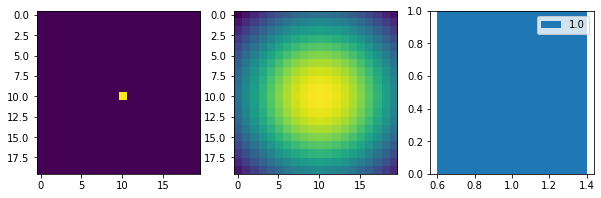

In [3]:
stim, pos = generate_stimuli()
prf = generate_prf() 
prf_resp = stim.flatten() @ prf.flatten()

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(10, 3)

axs[0].imshow(stim[:,:])

axs[1].imshow(prf)
axs[2].bar(1, prf_resp)
axs[2].legend([prf_resp])
axs[2].set_ylim([0, 1])

In [4]:
size = 40
n_pos = 16
target_ecc = 7
near_ecc = 1.5
n_ecc = 50
sd = 4.5
filt_size = 30

print("Generating voxels...")
voxels = generate_voxels(n_eccentricities = n_ecc)
prf_maps = np.zeros([size, size, voxels.shape[0]])
print("Generating Stimuli...")
stims, positions, angles = generate_isostim(target_ecc, n_pos, size = size)
print("Generating LTM simulated sources...")
ltm_stims = gen_LTMstims(stims, size, filt_size = filt_size, sd = sd)
l, s, ltm_stims = gen_radialgauss(stims, generate_prf(size = filt_size, sd = 1), distnorm = True)

print("Generating pRF maps...")
for i, v in enumerate(voxels):
    x, y, ecc, prf_size = v
    prf_maps[:, :, i] = generate_prf(center = [x, y], size = size, sd = prf_size)

print("Generating pRF responses...")
parf_perception = gen_pRFresponses(near_ecc, target_ecc, stims, prf_maps, voxels, positions)
parf_ltm = gen_pRFresponses(near_ecc, target_ecc, ltm_stims, prf_maps, voxels, positions) 



Generating voxels...
Generating Stimuli...
Generating LTM simulated sources...
Generating pRF maps...
Generating pRF responses...


In [5]:
# TODO: Generate prfresponses for each stimuli before initializing widget - for faster visualization
@widgets.interact(slice=widgets.IntSlider(min=0, max=stims.shape[-1] - 1, step=1, value=0))
def plot_prfs(slice):
    ''' ----- Perception ----- '''
    stim = stims[:, :, slice]
    angle_s = angles[slice]
    pos = positions[slice]
    #angle = np.arctan2(pos[1], pos[0])
    coords = np.where(stim == 1)
    threshold = 0.01

    fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(15, 8)


    axs[0, 1].scatter(parf_perception[:, 0, slice], parf_perception[:, 1, slice], s = 5, c = parf_perception[:, -1, slice])
    axs[0, 1].scatter(positions[slice, 0], positions[slice, 1], color = 'orange')

    zero_idxs = np.where(parf_perception[:, 5, slice] <= threshold)

    axs[0, 1].scatter(parf_perception[zero_idxs, 0, slice], parf_perception[zero_idxs, 1, slice], color = 'red', s=3)

    xmax = parf_perception[np.where(parf_perception[:, -1, slice] == parf_perception[:, -1, slice].max()), 0]
    ymax = parf_perception[np.where(parf_perception[:, -1, slice] == parf_perception[:, -1, slice].max()), 1]

    axs[0, 1].set_xlim([-20, 20])
    axs[0, 1].set_ylim([-20, 20])
    axs[0, 1].axis('equal')
    axs[0, 2].scatter(parf_perception[:, 4, slice], parf_perception[:, 5, slice])
    axs[0, 2].set_ylim([0, 1])
    axs[0, 2].set_xlim([-np.pi, np.pi])

    axs[0, 0].imshow(stim, origin = 'lower', vmax = 1)
    
    axs[0, 0].set_title('Source Input (Stimulus)')
    axs[0, 1].set_title('Voxel-wise map')
    axs[0, 2].set_title('1D Polar Angle Response Function')
    axs[0, 0].set_ylabel('Perception')
    axs[1, 0].set_ylabel('LTM')
    axs[1, 0].set_xlabel('Degrees')
    axs[1, 1].set_xlabel('Degrees')
    axs[1, 2].set_xlabel('Distance from Target (Degrees)')
    axs[0, 1].scatter(0, 0, marker = "+")
    axs[0, 1].legend(['Voxels', 'Stimulus', 'Sub-threshold voxels'], loc = 'lower left',
                 fontsize = 8)
    
    ''' ----- LTM -----'''
    near_ecc = 2
    ltm_stim = ltm_stims[:, :, slice]
    angle_s = angles[slice]
    pos = positions[slice]
    #angle = np.arctan2(pos[1], pos[0])
    coords = np.where(stim == 1)
    
    print("\tRed Vox Threshold:", threshold)


    axs[1, 1].scatter(parf_ltm[:, 0, slice], parf_ltm[:, 1, slice], s = 5, c = parf_ltm[:, -1, slice])
    axs[1, 1].scatter(positions[slice, 0], positions[slice, 1], color = 'orange')
    axs[1, 1].scatter(0, 0, marker = "+")

    zero_idxs = np.where(parf_ltm[:, 5, slice] <= threshold)

    axs[1, 1].scatter(parf_ltm[zero_idxs, 0, slice], parf_ltm[zero_idxs, 1, slice], color = 'red', s=3)

    xmax = parf_ltm[np.where(parf_ltm[:, -1, slice] == parf_ltm[:, -1, slice].max()), 0]
    ymax = parf_ltm[np.where(parf_ltm[:, -1, slice] == parf_ltm[:, -1, slice].max()), 1]

    axs[1, 1].set_xlim([-20, 20])
    axs[1, 1].set_ylim([-20, 20])
    axs[1, 1].axis('equal')
    axs[1, 2].scatter(parf_ltm[:, 4, slice], parf_ltm[:, 5, slice])
    axs[1, 2].set_ylim([0, 1])
    axs[1, 2].set_xlim([-np.pi, np.pi])
    
    ltm_stim_fix = ltm_stim.copy()
    ltm_stim_fix[int(ltm_stim.shape[0]/2), int(ltm_stim.shape[0]/2)] = -np.max(ltm_stim)
    axs[1, 0].imshow(ltm_stim_fix, origin = 'lower')
    plt.show()
    

interactive(children=(IntSlider(value=0, description='slice', max=15), Output()), _dom_classes=('widget-intera…

(0.0, 1.0)

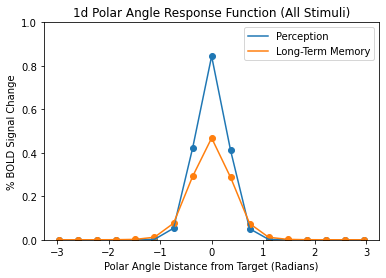

In [6]:
pct_signal_ltm = parf_ltm[:, -1, :].flatten()
pct_signal_perc = parf_perception[:, -1, :].flatten()
angle_diff = parf_ltm[:, -2, :].flatten() 

angle_diff[angle_diff <= -np.pi] = angle_diff[angle_diff <= -np.pi] + 2*np.pi
angle_diff[angle_diff >= np.pi] = angle_diff[angle_diff >= np.pi] - 2*np.pi

bins_idxs = np.linspace(-np.pi, np.pi, 18)
bins = np.stack([bins_idxs[:-1], bins_idxs[1:]], axis = 1)

parf_ltm_bin = np.zeros([len(bins), 2])
parf_perc_bin = np.zeros(parf_ltm_bin.shape)

for i, b in enumerate(bins):
    idxs = np.where((angle_diff >= b[0]) & (angle_diff <= b[1]))
    parf_ltm_bin[i] = np.array([np.mean(angle_diff[idxs]), np.mean(pct_signal_ltm[idxs])])
    parf_perc_bin[i] = np.array([np.mean(angle_diff[idxs]), np.mean(pct_signal_perc[idxs])])

    
plt.plot(parf_perc_bin[:, 0], parf_perc_bin[:, 1])
plt.plot(parf_ltm_bin[:, 0], parf_ltm_bin[:, 1])
plt.scatter(parf_perc_bin[:, 0], parf_perc_bin[:, 1])
plt.scatter(parf_ltm_bin[:, 0], parf_ltm_bin[:, 1])
plt.title("1d Polar Angle Response Function (All Stimuli)")
plt.ylabel("% BOLD Signal Change")
plt.xlabel("Polar Angle Distance from Target (Radians)")
plt.legend(["Perception", "Long-Term Memory"])
plt.ylim([0, 1])

In [14]:
import cv2
import numpy as np
center = [0, 0]
y_warp = 2   # Bias to encode polar angle 
x_warp = 1   # Bias to encode eccentricity
sd = 8
s = 0
    
size = 100
n_ecc = 20
target_ecc = 7
near_ecc = 3
n_pos = 16

voxels = generate_voxels(n_eccentricities = n_ecc)
prf_maps = np.zeros([size, size, voxels.shape[0]])
stims, positions, angles = generate_isostim(target_ecc, n_pos, size = size)

for j, v in enumerate(voxels):
    x, y, ecc, prf_size = v
    prf_maps[:, :, j] = generate_prf(center = [x, y], size = size, sd = prf_size)

center_cart = [(center[0] + size/2), (center[1] + size/2)]
origin = np.array([size/2, size/2])

# Generate ring stimuli
ring = np.zeros(stims.shape[:2])
c = np.array([size/2, size/2])
for x in range(ring.shape[1]):
    for y in range(ring.shape[0]):
        row = int(y)
        col = int(x)
        
        ecc = np.linalg.norm(np.array([col, row]) - c)
        if (ecc >= 5) & (ecc <= 7):
            ring[row, col] = 1

# stim = generate_prf(center, size = size, sd = 3)      
stim = ring
# stim = stims[:, :, s] 

value = np.sqrt(((size/2.0)**2.0)+((size/2.0)**2.0))

filt = generate_prf_warp(size = 100, sd = sd, y_warp = y_warp, x_warp = x_warp)

polars, logpolars = gen_polarstims(stims, filt, origin, radius = value)

# Compute prf tuning curve
parf_polar = gen_pRFresponses(near_ecc, target_ecc, polars, prf_maps, voxels, positions).squeeze()
parf_log = gen_pRFresponses(near_ecc, target_ecc, logpolars, prf_maps, voxels, positions).squeeze()

pct_signal_polar = parf_polar[:, -1, :].flatten()
pct_signal_log = parf_log[:, -1, :].flatten()
angle_diff = parf_polar[:, -2, :].flatten() 

# angle_diff[angle_diff <= -np.pi] = angle_diff[angle_diff <= -np.pi] + 2*np.pi
# angle_diff[angle_diff >= np.pi] = angle_diff[angle_diff >= np.pi] - 2*np.pi

bins_idxs = np.linspace(-np.pi, np.pi, 18)
bins = np.stack([bins_idxs[:-1], bins_idxs[1:]], axis = 1)

parf_polar_bin = np.zeros([len(bins), 2])
parf_log_bin = np.zeros(parf_polar_bin.shape)

for j, b in enumerate(bins):
    idxs = np.where((angle_diff >= b[0]) & (angle_diff <= b[1]))
    parf_polar_bin[j] = np.array([np.mean(angle_diff[idxs]), np.nanmean(pct_signal_polar[idxs])])
    parf_log_bin[j] = np.array([np.mean(angle_diff[idxs]), np.nanmean(pct_signal_log[idxs])])

(0.0, 1.0)

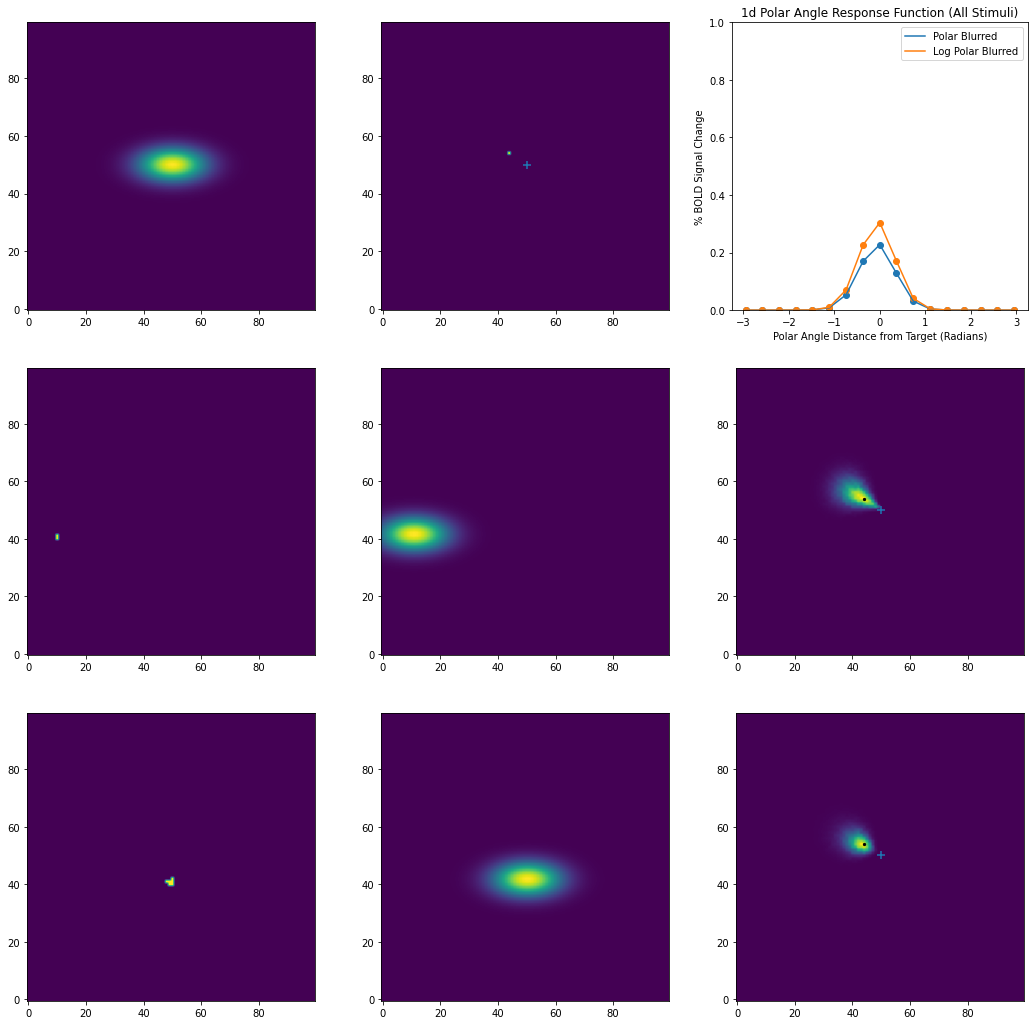

In [15]:
# Plot
# Example polar log images for plotting
s = 13
stim = stims[:, :, s]
#stim = ring
pos = np.where(stim == 1)

# Linear Polar
stim_polar = cv2.warpPolar(stim, stim.shape, origin, value, cv2.WARP_FILL_OUTLIERS + cv2.WARP_POLAR_LINEAR)
angle_change = size/2 - np.where(stim_polar == np.amax(stim_polar))[0][0]
stim_polarr = np.roll(stim_polar, int(angle_change) , axis = 0)
stim_pconv = sp.convolve2d(stim_polarr, filt, mode = 'same', boundary = 'fill')
stim_pconv = np.roll(stim_pconv, -int(angle_change) , axis = 0)
stim_pconv_cart = cv2.warpPolar(stim_pconv, stim.shape, origin, value, cv2.WARP_INVERSE_MAP + cv2.WARP_POLAR_LINEAR + cv2.WARP_FILL_OUTLIERS)
stim_pconv_cart /= stim_pconv_cart.flatten().sum()

polars[:, :, s] = stim_pconv_cart

# Log Polar warp
stim_log = cv2.warpPolar(stim, stim.shape, origin, value, cv2.WARP_FILL_OUTLIERS + cv2.WARP_POLAR_LOG)
stim_logr = np.roll(stim_log, int(angle_change) , axis = 0)
stim_lconv = sp.convolve2d(stim_logr, filt, mode = 'same', boundary = 'circular')
stim_lconv = np.roll(stim_lconv, -int(angle_change) , axis = 0)
stim_lconv_cart = cv2.warpPolar(stim_lconv, stim.shape, origin, value, cv2.WARP_INVERSE_MAP + cv2.WARP_POLAR_LOG + cv2.WARP_FILL_OUTLIERS)
stim_lconv_cart /= stim_lconv_cart.flatten().sum()

fig, axs = plt.subplots(3, 3)
fig.set_size_inches(18, 18)

axs[0, 0].imshow(filt, origin = 'lower')
axs[0, 1].imshow(stim, origin = 'lower')

axs[1, 0].imshow(stim_polar, origin = 'lower')
axs[1, 1].imshow(stim_pconv, origin = 'lower')
axs[1, 2].imshow(stim_pconv_cart, origin = 'lower')
axs[1, 2].scatter(pos[1], pos[0], s = 5, c = 'black')
axs[2, 2].scatter(pos[1], pos[0], s = 5, c = 'black')
axs[1, 2].scatter(int(size/2), int(size/2), s = 50, marker = "+")
axs[2, 2].scatter(int(size/2), int(size/2), s = 50, marker = "+")
axs[0, 1].scatter(int(size/2), int(size/2), s = 50, marker = "+")

axs[2, 0].imshow(stim_log, origin = 'lower')
axs[2, 1].imshow(stim_lconv, origin = 'lower')
axs[2, 2].imshow(stim_lconv_cart, origin = 'lower')

# axs[0, 2].scatter(parf_polar[:, -2], parf_polar[:, -1])
# axs[0, 2].scatter(parf_log[:, -2], parf_log[:, -1])
# # axs[0, 2].scatter(parf_polar_bin[:, 0], parf_polar_bin[:, 1])
# # axs[0, 2].scatter(parf_log_bin[:, 0], parf_log_bin[:, 1])

axs[0, 2].plot(parf_polar_bin[:, 0], parf_polar_bin[:, 1])
axs[0, 2].plot(parf_log_bin[:, 0], parf_log_bin[:, 1])
axs[0, 2].scatter(parf_polar_bin[:, 0], parf_polar_bin[:, 1])
axs[0, 2].scatter(parf_log_bin[:, 0], parf_log_bin[:, 1])
axs[0, 2].set_title("1d Polar Angle Response Function (All Stimuli)")
axs[0, 2].set_ylabel("% BOLD Signal Change")
axs[0, 2].set_xlabel("Polar Angle Distance from Target (Radians)")
axs[0, 2].legend(["Polar Blurred", "Log Polar Blurred"])
axs[0, 2].set_ylim([0, 1])